In [36]:
#Python packages
import numpy as np
import pandas as pd
import re
from scipy import stats


#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#modeling packages
from catboost import CatBoostClassifier
from time import time
from tqdm import tqdm_notebook as tqdm

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from tqdm import tqdm


import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train_fin.csv', index_col=0)
spec = pd.read_csv('specs.csv', index_col=0)
train_labels = pd.read_csv('train_labels.csv', index_col=0)
test = pd.read_csv('test_fin.csv', index_col=0)

In [12]:
train['timestamp']= pd.to_datetime(train['timestamp'])

### LightGBM Model group_by installation_id

In [17]:
trains = train[train['installation_id'].isin(train_labels['installation_id'].unique())]
trains.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,...,time_by_phase_type,phase_of_day,practice_sec,assessment_prac,game_prac,months_played,recent_ratio,total_game_time,difficulty,assess_profile
1538,27253bdc,34ba1a28d02ba8ba,2019-08-06 04:57:18.904000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0.0,16,Clip,...,0.00,Night,25980.172,-999.0,-999.0,1.0,0.5,3800.0,0.0,0.0
1539,27253bdc,4b57c9a59474a1b9,2019-08-06 04:57:45.301000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0006a69f,1,2000,0.0,6,Clip,...,0.00,Night,25980.172,-999.0,-999.0,1.0,0.5,3800.0,0.0,0.0
1540,77261ab5,2b9d5af79bcdb79f,2019-08-06 04:58:14.538000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0006a69f,1,2000,0.0,0,Activity,...,184662.52,Night,25980.172,-999.0,-999.0,1.0,0.5,3800.0,1.0,0.0
1541,b2dba42b,2b9d5af79bcdb79f,2019-08-06 04:58:14.615000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0006a69f,2,3010,29.0,0,Activity,...,184662.52,Night,25980.172,-999.0,-999.0,1.0,0.5,3800.0,1.0,0.0
1542,1325467d,2b9d5af79bcdb79f,2019-08-06 04:58:16.680000+00:00,"{""coordinates"":{""x"":273,""y"":650,""stage_width"":...",0006a69f,3,4070,2137.0,0,Activity,...,184662.52,Night,25980.172,-999.0,-999.0,1.0,0.5,3800.0,1.0,0.0


In [24]:
def compute_game_time_stats(group, col):
    return group[
        ['installation_id', col, 'event_count', 'game_time']
    ].groupby(['installation_id', col]).agg(
        [np.mean, np.sum, np.std]
    ).reset_index().pivot(
        columns=col,
        index='installation_id'
    )

In [25]:
def group_and_reduce(df, df_labels):
    """
    Author: https://www.kaggle.com/xhlulu/
    Source: https://www.kaggle.com/xhlulu/ds-bowl-2019-simple-lgbm-using-aggregated-data
    """
    
    # First only filter the useful part of the df
    
    # group1 is am intermediary "game session" group,
    # which are reduced to one record by game session. group_game_time takes
    # the max value of game_time (final game time in a session) and 
    # of event_count (total number of events happened in the session).
    group_game_time = df.drop(columns=['event_id', 'event_code']).groupby(
        ['game_session', 'installation_id', 'title', 'type', 'world']
    ).max().reset_index()

    # group3, group4 are grouped by installation_id 
    # and reduced using summation and other summary stats
    title_group = (
        pd.get_dummies(
            group_game_time.drop(columns=['game_session', 'event_count', 'game_time']),
            columns=['title', 'type', 'world'])
        .groupby(['installation_id'])
        .sum()
    )

    event_game_time_group = (
        group_game_time[['installation_id', 'event_count', 'game_time']]
        .groupby(['installation_id'])
        .agg([np.sum, np.mean, np.std, np.min, np.max])
    )
    
    # Additional stats on group1
    world_time_stats = compute_game_time_stats(group_game_time, 'world')
    type_time_stats = compute_game_time_stats(group_game_time, 'type')
    
    return (
        title_group.join(event_game_time_group)
        .join(world_time_stats)
        .join(type_time_stats)
        .fillna(0)
    )


In [26]:
train_small = group_and_reduce(trains, train_labels)
print(train_small.shape)
print(train_small.head())

(3614, 127)
                 month  hour    year  dayofweek  weekofyear  dayofyear  \
installation_id                                                          
0006a69f           640   972  161520        131        2596      17743   
0006c192           461   439  100950        192        1890      13072   
00129856            80   131   18171         54         338       2357   
001d0ed0           468   710  104988        116        1895      13017   
00225f67           250   276   50475        138        1000       6963   

                 quarter  is_month_start  time_by_phase_type  practice_sec  \
installation_id                                                              
0006a69f             240             0.0         8047871.510   2078413.760   
0006c192             161            11.0         3245324.978   1872090.600   
00129856              27             0.0         1339768.819    126917.262   
001d0ed0             156             0.0         2243244.754   1189025.396   
0

In [32]:
submission = pd.read_csv('sample_submission.csv')

In [40]:
test_assess = test[test.type == 'Assessment'].copy()
test_labels = submission.copy()
test_labels['title'] = test_labels.installation_id.progress_apply(
    lambda install_id: test_assess[test_assess.installation_id == install_id].iloc[-1].title
)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 68.45it/s]


In [41]:
test_small = group_and_reduce(test,test_labels)
test_small.head()

,month,hour,year,dayofweek,weekofyear,dayofyear,quarter,is_month_start,time_by_phase_type,practice_sec,...,"(game_time, mean, Clip)","(game_time, mean, Game)","(game_time, sum, Activity)","(game_time, sum, Assessment)","(game_time, sum, Clip)","(game_time, sum, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)"
installation_id,,,,,,,,,,,,,,,,,,,,,
00abaee7,225,372,50475,51,925,6351,75,0.0,2310248.268,5.423572e+05,...,0.0,761743.000000,408599.0,30038.0,0.0,2285229.0,36886.664956,21240.073493,0.0,1.038605e+06
01242218,528,1227,117102,324,2222,15472,180,0.0,4768788.890,1.471952e+06,...,0.0,118409.083333,1608843.0,251298.0,0.0,1420909.0,98521.245018,32761.743006,0.0,3.779781e+04
017c5718,80,111,18171,44,335,2326,27,0.0,448426.180,3.117012e+04,...,0.0,0.000000,112850.0,0.0,0.0,0.0,6389.416875,0.000000,0.0,0.000000e+00
01a44906,98,215,28266,67,420,2909,42,0.0,722391.924,1.433608e+05,...,0.0,77204.000000,111064.0,0.0,0.0,77204.0,43064.217188,0.000000,0.0,0.000000e+00
01bc6cb6,208,414,50475,76,861,5928,75,0.0,1793271.464,8.888799e+05,...,0.0,164146.666667,221698.0,0.0,0.0,984880.0,0.000000,0.000000,0.0,1.780426e+05


In [44]:
train_labels.head()

,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
game_session,,,,,,
6bdf9623adc94d89,0006a69f,13,1,0,1.0,3
77b8ee947eb84b4e,0006a69f,43,0,11,0.0,0
901acc108f55a5a1,0006a69f,13,1,0,1.0,3
9501794defd84e4d,0006a69f,13,1,1,0.5,2
a9ef3ecb3d1acc6a,0006a69f,43,1,0,1.0,3


In [45]:
def preprocess_train(train_labels, last_records_only=True):
    """
    last_records_only (bool): Use only the last record of each user.
    """
    final_train = pd.get_dummies(
        (
            train_labels.set_index('installation_id')
            .drop(columns=['num_correct', 'num_incorrect', 'accuracy'])
            .join(train_small)
        ), 
        columns=['title']
    )
    
    if last_records_only:
        final_train = (
            final_train
            .reset_index()
            .groupby('installation_id')
            .apply(lambda x: x.iloc[-1])
            .drop(columns='installation_id')
        )
    return final_train

def preprocess_test(test_labels, test_small):
    return pd.get_dummies(
        test_labels.set_index('installation_id').join(test_small), columns=['title']
    )

In [46]:
final_train = preprocess_train(train_labels)
final_train.head()

,accuracy_group,month,hour,year,dayofweek,weekofyear,dayofyear,quarter,is_month_start,time_by_phase_type,...,"(game_time, sum, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)",title_13,title_25,title_29,title_37,title_43
installation_id,,,,,,,,,,,,,,,,,,,,,
0006a69f,3,640,972,161520,131,2596,17743,240,0.0,8047871.510,...,2139329.0,350054.566401,28330.303185,0.0,58189.254197,0,0,0,0,1
0006c192,0,461,439,100950,192,1890,13072,161,11.0,3245324.978,...,530073.0,127422.782500,98940.202632,0.0,62500.291205,1,0,0,0,0
00129856,3,80,131,18171,54,338,2357,27,0.0,1339768.819,...,0.0,130499.803239,28043.854942,0.0,0.000000,0,0,0,0,1
001d0ed0,3,468,710,104988,116,1895,13017,156,0.0,2243244.754,...,950557.0,24694.997226,17737.374861,0.0,123969.846618,1,0,0,0,0
00225f67,0,250,276,50475,138,1000,6963,100,0.0,1651150.470,...,519939.0,49028.831364,12301.536672,0.0,65432.543128,0,0,0,0,1


In [70]:
final_train.shape

(3614, 133)

In [48]:
final_test = preprocess_test(test_labels, test_small)
final_test.head()

,accuracy_group,month,hour,year,dayofweek,weekofyear,dayofyear,quarter,is_month_start,time_by_phase_type,...,"(game_time, sum, Game)","(game_time, std, Activity)","(game_time, std, Assessment)","(game_time, std, Clip)","(game_time, std, Game)",title_13,title_25,title_29,title_37,title_43
installation_id,,,,,,,,,,,,,,,,,,,,,
00abaee7,3,225,372,50475,51,925,6351,75,0.0,2310248.268,...,2285229.0,36886.664956,21240.073493,0.0,1.038605e+06,0,1,0,0,0
01242218,3,528,1227,117102,324,2222,15472,180,0.0,4768788.890,...,1420909.0,98521.245018,32761.743006,0.0,3.779781e+04,0,0,0,1,0
017c5718,3,80,111,18171,44,335,2326,27,0.0,448426.180,...,0.0,6389.416875,0.000000,0.0,0.000000e+00,1,0,0,0,0
01a44906,3,98,215,28266,67,420,2909,42,0.0,722391.924,...,77204.0,43064.217188,0.000000,0.0,0.000000e+00,1,0,0,0,0
01bc6cb6,3,208,414,50475,76,861,5928,75,0.0,1793271.464,...,984880.0,0.000000,0.000000,0.0,1.780426e+05,0,0,0,1,0


In [49]:
def cv_train(X, y, cv, **kwargs):
    """
    Author: https://www.kaggle.com/xhlulu/
    Source: https://www.kaggle.com/xhlulu/ds-bowl-2019-simple-lgbm-using-aggregated-data
    """
    models = []
    
    kf = KFold(n_splits=cv, random_state=2019)
    
    for train, test in kf.split(X):
        x_train, x_val, y_train, y_val = X[train], X[test], y[train], y[test]
        
        train_set = lgb.Dataset(x_train, y_train)
        val_set = lgb.Dataset(x_val, y_val)
        
        model = lgb.train(train_set=train_set, valid_sets=[train_set, val_set], **kwargs)
        models.append(model)
        
        if kwargs.get("verbose_eval"):
            print("\n" + "="*50 + "\n")
    
    return models

def cv_predict(models, X):
    return np.mean([model.predict(X) for model in models], axis=0)

In [50]:
X = final_train.drop(columns='accuracy_group').values
y = final_train['accuracy_group'].values

params = {
    'learning_rate': 0.01,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.2,
    'max_height': 3,
    'lambda_l1': 10,
    'lambda_l2': 10,
    'metric': 'multiclass',
    'objective': 'multiclass',
    'num_classes': 4,
    'random_state': 2019
}

models = cv_train(X, y, cv=20, params=params, num_boost_round=1000,
                  early_stopping_rounds=100, verbose_eval=500)

Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.913583	valid_1's multi_logloss: 0.97886
[1000]	training's multi_logloss: 0.804572	valid_1's multi_logloss: 0.944361
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.804572	valid_1's multi_logloss: 0.944361


Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.912042	valid_1's multi_logloss: 1.03137
[1000]	training's multi_logloss: 0.803203	valid_1's multi_logloss: 0.992513
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.803203	valid_1's multi_logloss: 0.992513


Training until validation scores don't improve for 100 rounds
[500]	training's multi_logloss: 0.911965	valid_1's multi_logloss: 1.06272
[1000]	training's multi_logloss: 0.804381	valid_1's multi_logloss: 1.03661
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.804381	valid_1's multi_logloss

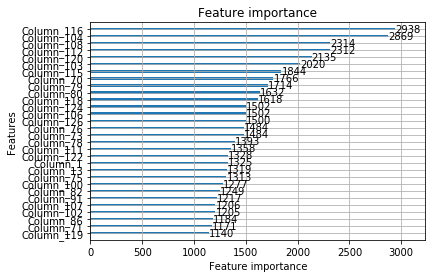

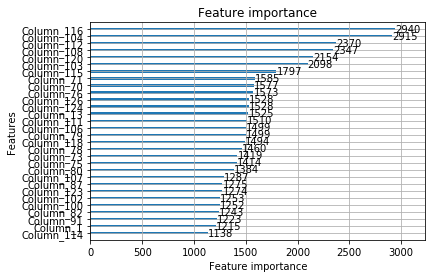

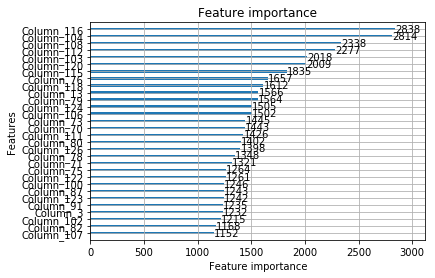

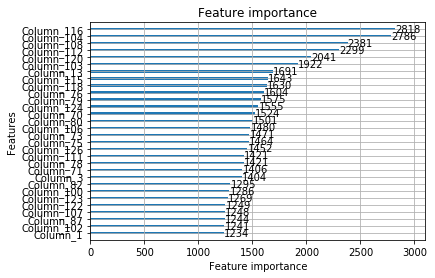

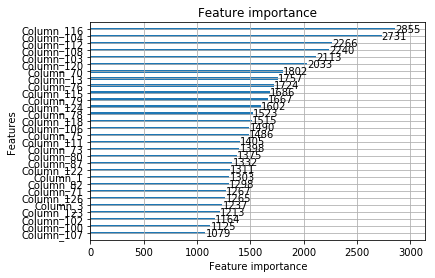

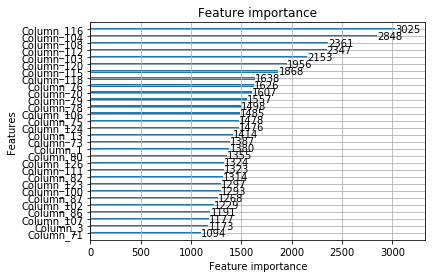

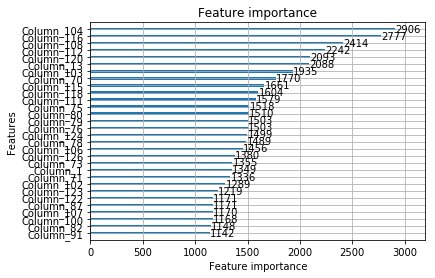

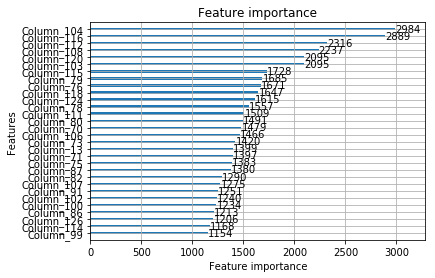

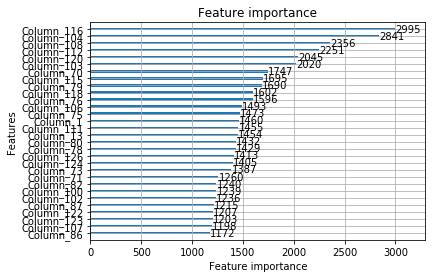

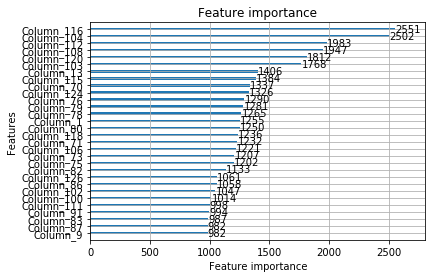

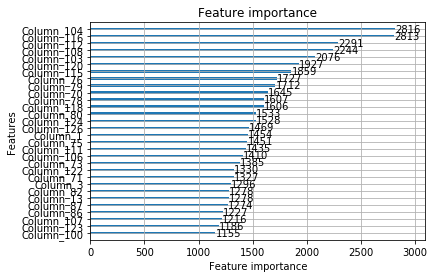

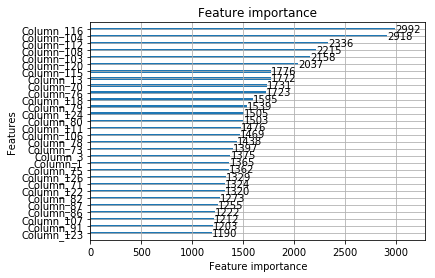

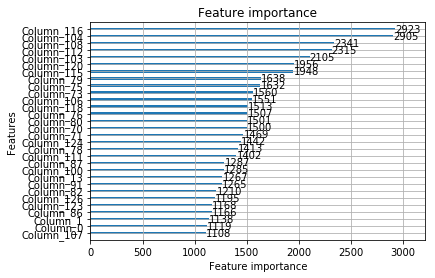

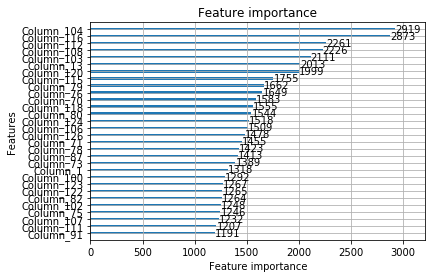

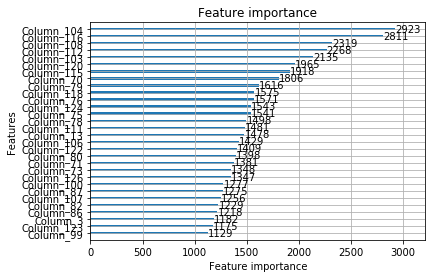

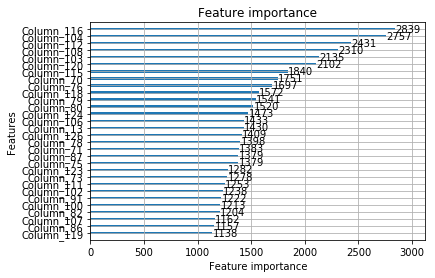

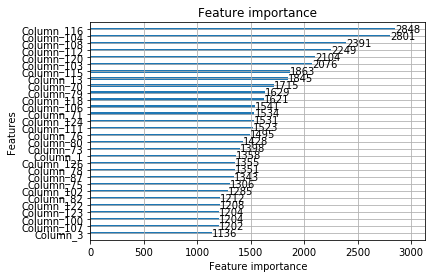

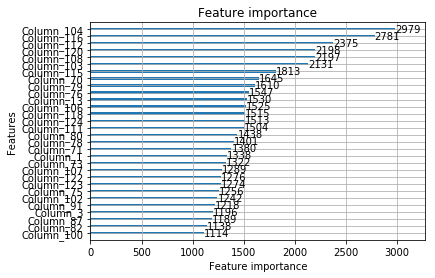

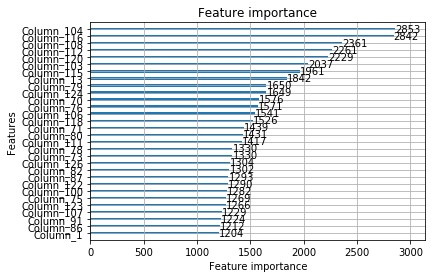

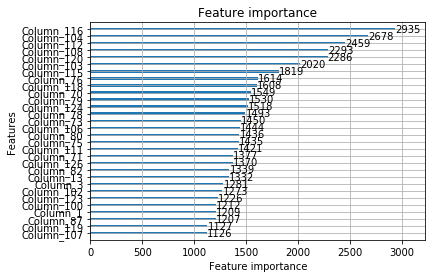

In [64]:
for model in models:
    lgb.plot_importance(model, max_num_features=30, height=0.3)

In [58]:
X_test = final_test.drop(columns=['accuracy_group'])
test_pred = cv_predict(models=models, X=X_test).argmax(axis=1)

final_test['accuracy_group'] = test_pred
final_test[['accuracy_group']].to_csv('submission.csv')

In [65]:
print(final_test[['accuracy_group']].shape)
print(samp.shape)

(1000, 1)
(1000, 1)
